# Catchment Boundary Derivation â€” ausvic (FloodHubMaribyrnong)

**Prerequisite:** Run `0a-derive_gauge_config_ausvic.ipynb` first â€” it saves
`gauges_ausvic.json` to Google Drive which this notebook loads.

Derives upstream catchment boundary polygons for all Maribyrnong River gauging
stations using **HydroBASINS Level 12** hosted in Google Earth Engine.

**Method**
1. Load `GAUGES` from `gauges_ausvic.json` (output of 0a)
2. Find the HydroBASINS Level-12 cell containing each gauge point
3. Iteratively trace upstream via `NEXT_DOWN` links
4. Union all upstream cells into a single catchment polygon per gauge
5. Save combined GeoJSON + ESRI Shapefile to Google Drive
6. Visualise catchments (static map + interactive map)

**Output** (saved to `My Drive/caravan_maribyrnong_gee/shapefiles/`)
- `ausvic_basin_shapes.geojson` â€” combined FeatureCollection
- `ausvic_basin_shapes.shp/.shx/.dbf/.prj/.cpg` â€” Caravan-format shapefile
- `ausvic_catchments_map.png` â€” static map image

**Next step:** Upload the shapefile to GEE as an asset named
`projects/floodhubmaribyrnong/assets/ausvic_basin_shapes`
for use in `Caravan_part1_Earth_Engine_ausvic.ipynb`.

In [42]:
# Install dependencies (earthengine-api is pre-installed in Colab)
%pip install -q geopandas folium

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import ee
ee.Authenticate()
ee.Initialize(project='floodhubmaribyrnong')

In [45]:
import json
from pathlib import Path

# HydroBASINS Level 12 — hosted in GEE
GEE_BASINS = 'WWF/HydroSHEDS/v1/Basins/hybas_12'

# Output directory on Google Drive
OUT_DIR = Path('/content/drive/MyDrive/caravan_maribyrnong_gee/shapefiles')
OUT_DIR.mkdir(parents=True, exist_ok=True)
print(f'Output dir: {OUT_DIR}')


Output dir: /content/drive/MyDrive/caravan_maribyrnong_gee/shapefiles


In [46]:
# â”€â”€ Load GAUGES from 0a JSON â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€
# Run 0a-derive_gauge_config_ausvic.ipynb first â€” it saves gauges_ausvic.json.

GAUGES_JSON = Path('/content/drive/MyDrive/caravan_maribyrnong_gee/gauges_ausvic.json')

if not GAUGES_JSON.exists():
    raise FileNotFoundError(
        f'{GAUGES_JSON} not found.\n'
        'Run 0a-derive_gauge_config_ausvic.ipynb first to generate this file.'
    )

with open(GAUGES_JSON) as f:
    GAUGES = json.load(f)

print(f'Loaded {len(GAUGES)} gauges from Drive JSON')
for g in GAUGES:
    print(f"  {g['gauge_id']:20s}  {g['name']}")

Loaded 12 gauges from Drive JSON
  ausvic_230119         Maribyrnong River at Lancefield
  ausvic_230100         Deep Creek at Darraweit Guim
  ausvic_230102         Deep Creek at Bulla
  ausvic_230211         Bolinda Creek at Clarkefield
  ausvic_230107         Konagaderra Creek at Konagaderra
  ausvic_230237         Maribyrnong River at Keilor North
  ausvic_230200         Maribyrnong River at Keilor
  ausvic_230106         Maribyrnong River at Chifley Drive
  ausvic_230206         Jackson Creek at Gisborne
  ausvic_230202         Jackson Creek at Sunbury
  ausvic_230213         Turritable Creek at Mount Macedon
  ausvic_230227         Main Creek at Kerrie


In [47]:
def trace_upstream(lat, lon, gauge_id, known_area=None):
    """
    Collect every HydroBASINS Level-12 cell upstream of (lat, lon),
    union them into one polygon, and return a GeoJSON Feature.

    Uses the HydroBASINS L12 cell that geometrically contains the gauge point
    as the outlet (standard Caravan approach).  Where multiple gauges snap to
    the same outlet cell, the shared-cell report below flags them and confirms
    that MERIT Hydro area_km2 values are used for streamflow conversion.
    """
    basins = ee.FeatureCollection(GEE_BASINS)
    point  = ee.Geometry.Point([lon, lat])

    # 1. Find the outlet basin cell
    print(f'  Finding outlet basin at ({lat}, {lon}) ...')
    outlet      = basins.filterBounds(point).first()
    outlet_info = outlet.getInfo()

    if outlet_info is None:
        raise RuntimeError(f'No HydroBASINS basin found at ({lat}, {lon})')

    props     = outlet_info['properties']
    outlet_id = props['HYBAS_ID']
    up_area   = props['UP_AREA']
    print(f'  Outlet HYBAS_ID : {outlet_id}')
    print(f'  Outlet UP_AREA  : {up_area:.1f} km2')

    # 2. Iteratively trace upstream via NEXT_DOWN links
    print('  Tracing upstream basins ...')
    all_ids  = {outlet_id}
    frontier = {outlet_id}
    iteration = 0

    while frontier:
        iteration += 1
        parents    = basins.filter(ee.Filter.inList('NEXT_DOWN', list(frontier)))
        parent_ids = parents.aggregate_array('HYBAS_ID').getInfo()
        new_ids    = set(parent_ids) - all_ids

        print(f'    Iteration {iteration}: {len(new_ids)} new basin(s) '
              f'(running total: {len(all_ids) + len(new_ids)})')

        if not new_ids:
            break

        all_ids.update(new_ids)
        frontier = new_ids

    print(f'  Total basins in catchment: {len(all_ids)}')

    # 3. Union all upstream polygons (30 m tolerance)
    print('  Unioning polygons ...')
    upstream_fc = basins.filter(ee.Filter.inList('HYBAS_ID', list(all_ids)))
    merged      = upstream_fc.union(maxError=30).first()
    merged_info = merged.getInfo()

    return {
        'type': 'Feature',
        'properties': {
            'gauge_id':        gauge_id,
            'up_area_km2':     up_area,
            'outlet_hybas_id': outlet_id,   # kept for shared-cell detection below
        },
        'geometry': merged_info['geometry'],
    }


In [48]:
# ── Run upstream trace for all gauges ─────────────────────────────────────────
all_features = []

for gauge in GAUGES:
    gid        = gauge['gauge_id']
    known_area = gauge.get('area_km2')

    print(f"\n{'=' * 60}")
    print(f"Gauge: {gauge['name']} ({gid})")
    print(f"{'=' * 60}")
    if known_area:
        print(f'  Known catchment area: {known_area} km2')

    try:
        feature = trace_upstream(gauge['lat'], gauge['lon'], gid)
    except Exception as exc:
        print(f'  ERROR: {exc}')
        continue

    hydrobasins_area = feature['properties']['up_area_km2']
    if known_area:
        diff_pct = abs(hydrobasins_area - known_area) / known_area * 100
        print(f'  Area check: HydroBASINS={hydrobasins_area:.1f} km2  '
              f'known={known_area} km2  diff={diff_pct:.1f}%')

    all_features.append(feature)

print(f'\nProcessed {len(all_features)} / {len(GAUGES)} gauges successfully')



Gauge: Maribyrnong River at Lancefield (ausvic_230119)
  Known catchment area: 226.1 km2
  Finding outlet basin at (-37.28609024, 144.7777498) ...
  Outlet HYBAS_ID : 5120610000
  Outlet UP_AREA  : 349.2 km2
  Tracing upstream basins ...
    Iteration 1: 1 new basin(s) (running total: 2)
    Iteration 2: 0 new basin(s) (running total: 2)
  Total basins in catchment: 2
  Unioning polygons ...
  Area check: HydroBASINS=349.2 km2  known=226.1 km2  diff=54.4%

Gauge: Deep Creek at Darraweit Guim (ausvic_230100)
  Known catchment area: 481.5 km2
  Finding outlet basin at (-37.41031306, 144.9022845) ...
  Outlet HYBAS_ID : 5120611030
  Outlet UP_AREA  : 682.7 km2
  Tracing upstream basins ...
    Iteration 1: 2 new basin(s) (running total: 3)
    Iteration 2: 1 new basin(s) (running total: 4)
    Iteration 3: 0 new basin(s) (running total: 4)
  Total basins in catchment: 4
  Unioning polygons ...
  Area check: HydroBASINS=682.7 km2  known=481.5 km2  diff=41.8%

Gauge: Deep Creek at Bulla (a

In [49]:
# â”€â”€ Shared HydroBASINS outlet-cell detection â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€
#
# Before this fix, all three lower-mainstem gauges snapped to the same
# HydroBASINS Level-12 cell: HYBAS_ID 5120612070 (UP_AREA = 1413.6 kmÂ²).
# That meant identical polygons AND identical areas for gauges that are
# actually 5â€“100 kmÂ² apart.
#
# MERIT Hydro (90 m) resolves each gauge individually â€” those corrected
# area_km2 values come from notebook 0a and are what the pipeline uses for
# streamflow unit conversion (ML/day â†’ mm/day).
#
# Polygon geometry: HydroBASINS L12 is still too coarse to give distinct
# polygons for co-located lower-mainstem gauges.  The shared polygon is a
# known limitation; the area correction is the high-impact fix.

from collections import defaultdict

# Group features by outlet HYBAS_ID
hybas_groups = defaultdict(list)
for f in all_features:
    hid = f['properties']['outlet_hybas_id']
    hybas_groups[hid].append(f['properties']['gauge_id'])

# Lookup tables
known_areas      = {g['gauge_id']: g.get('area_km2') for g in GAUGES}
hydrobasins_area = {f['properties']['gauge_id']: f['properties']['up_area_km2']
                    for f in all_features}

shared_cells = {hid: gids for hid, gids in hybas_groups.items() if len(gids) > 1}

if not shared_cells:
    print('All gauges have distinct HydroBASINS outlet cells â€” no shared polygons.')
else:
    print(f'WARNING: {len(shared_cells)} shared HydroBASINS outlet cell(s) detected\n')

    for hybas_id, gids in sorted(shared_cells.items()):
        hb_area = hydrobasins_area[gids[0]]  # identical for all gauges in group
        print(f'  HYBAS_ID {hybas_id}  (HydroBASINS UP_AREA = {hb_area:.1f} km2)')
        print(f'  {len(gids)} gauges share this outlet cell:\n')
        print(f'  {"gauge_id":<22}  {"before":>18}  {"after (MERIT)":>18}  {"delta":>8}')
        print('  ' + '-' * 72)

        for gid in sorted(gids, key=lambda g: known_areas.get(g) or 0):
            before    = hb_area
            after     = known_areas.get(gid)
            after_str = f'{after:.1f}' if after is not None else 'unknown'
            if after is not None:
                delta_pct = (after - before) / before * 100
                delta_str = f'{delta_pct:+.1f}%'
            else:
                delta_str = 'â€”'
            print(f'  {gid:<22}  {before:>18.1f}  {after_str:>18}  {delta_str:>8}')

        print()
        print('  Polygon geometry: identical for all gauges in this group')
        print('  (HydroBASINS L12 too coarse to distinguish co-located gauges)')
        print('  Area used by pipeline: MERIT Hydro 90 m values above')
        print()



  HYBAS_ID 5120611030  (HydroBASINS UP_AREA = 682.7 km2)
  2 gauges share this outlet cell:

  gauge_id                            before       after (MERIT)     delta
  ------------------------------------------------------------------------
  ausvic_230100                        682.7               481.5    -29.5%
  ausvic_230107                        682.7               618.0     -9.5%

  Polygon geometry: identical for all gauges in this group
  (HydroBASINS L12 too coarse to distinguish co-located gauges)
  Area used by pipeline: MERIT Hydro 90 m values above

  HYBAS_ID 5120611070  (HydroBASINS UP_AREA = 177.9 km2)
  2 gauges share this outlet cell:

  gauge_id                            before       after (MERIT)     delta
  ------------------------------------------------------------------------
  ausvic_230211                        177.9                94.9    -46.7%
  ausvic_230227                        177.9               177.8     -0.1%

  Polygon geometry: identical fo

In [50]:
# â”€â”€ Save GeoJSON â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€
# Strip up_area_km2 â€” Caravan standard requires gauge_id only

clean_features = [
    {
        'type': 'Feature',
        'properties': {'gauge_id': f['properties']['gauge_id']},
        'geometry': f['geometry'],
    }
    for f in all_features
]

fc = {'type': 'FeatureCollection', 'features': clean_features}

geojson_path = OUT_DIR / 'ausvic_basin_shapes.geojson'
geojson_path.write_text(json.dumps(fc, indent=2))

print(f'GeoJSON saved: {geojson_path}')
print(f'  Features : {len(clean_features)}')
print(f'  IDs      : {[f["properties"]["gauge_id"] for f in clean_features]}')

GeoJSON saved: /content/drive/MyDrive/caravan_maribyrnong_gee/shapefiles/ausvic_basin_shapes.geojson
  Features : 12
  IDs      : ['ausvic_230119', 'ausvic_230100', 'ausvic_230102', 'ausvic_230211', 'ausvic_230107', 'ausvic_230237', 'ausvic_230200', 'ausvic_230106', 'ausvic_230206', 'ausvic_230202', 'ausvic_230213', 'ausvic_230227']


In [51]:
# â”€â”€ Save ESRI Shapefile â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€
# Caravan requires a SINGLE combined shapefile with gauge_id column only.

import geopandas as gpd

gdf = gpd.read_file(str(geojson_path))
gdf = gdf[['gauge_id', 'geometry']]   # Caravan: gauge_id column only

shp_path = OUT_DIR / 'ausvic_basin_shapes.shp'
gdf.to_file(str(shp_path))            # writes .shp/.shx/.dbf/.prj/.cpg

print(f'Shapefile saved: {shp_path}')
print(gdf[['gauge_id']].to_string())

Shapefile saved: /content/drive/MyDrive/caravan_maribyrnong_gee/shapefiles/ausvic_basin_shapes.shp
         gauge_id
0   ausvic_230119
1   ausvic_230100
2   ausvic_230102
3   ausvic_230211
4   ausvic_230107
5   ausvic_230237
6   ausvic_230200
7   ausvic_230106
8   ausvic_230206
9   ausvic_230202
10  ausvic_230213
11  ausvic_230227


## Visualise Catchment Boundaries

Two views of the catchment polygons:
- **Static map** â€” saved as PNG to Google Drive
- **Interactive map** â€” explore in-notebook with zoom and click popups

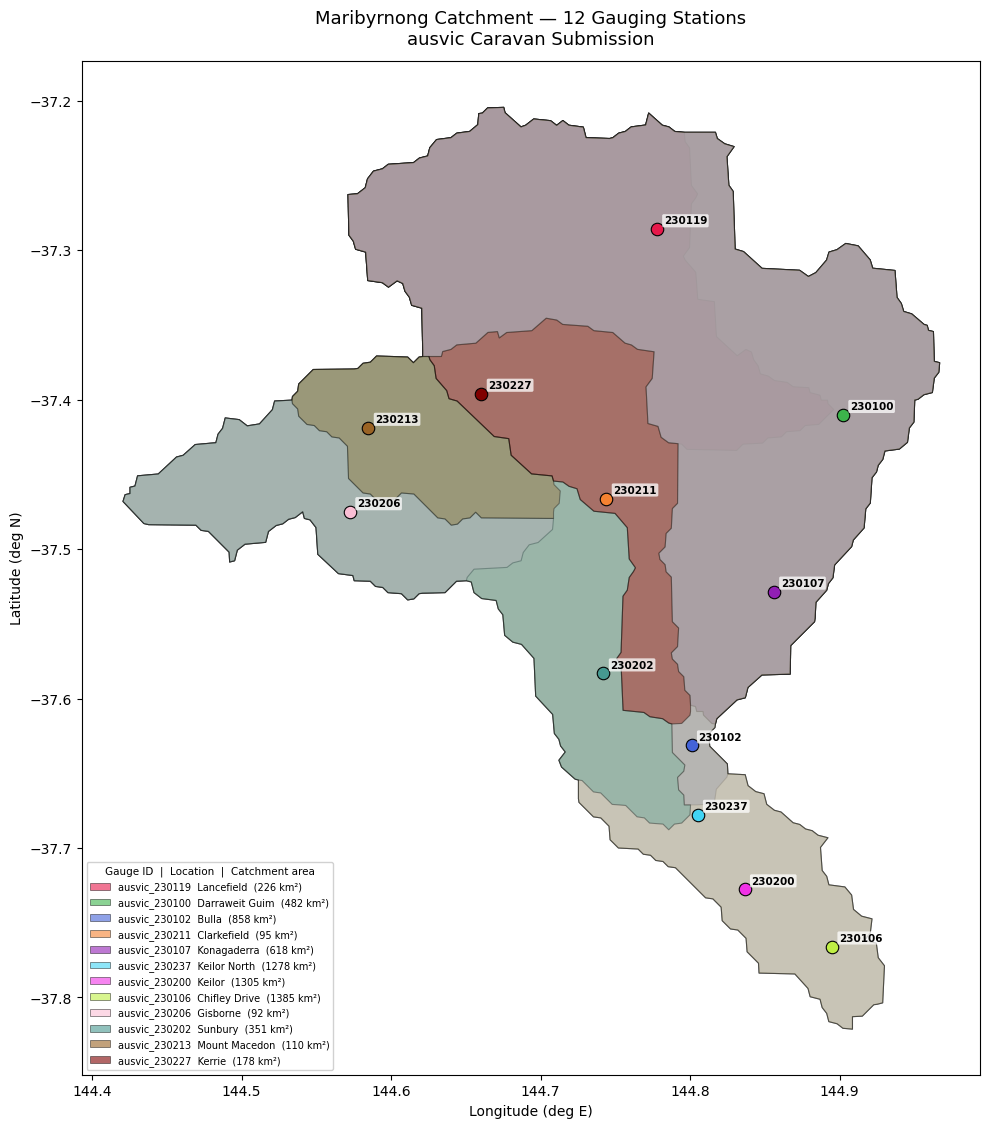

Static map saved: /content/drive/MyDrive/caravan_maribyrnong_gee/shapefiles/ausvic_catchments_map.png


In [52]:
# ── Static map (matplotlib) ───────────────────────────────────────────────────
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 12 visually distinct colours
COLORS = [
    '#e6194b', '#3cb44b', '#4363d8', '#f58231', '#911eb4',
    '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990',
    '#9a6324', '#800000',
]

# Build gauge_id -> colour mapping (same order as GAUGES list)
gauge_color = {g['gauge_id']: COLORS[i % len(COLORS)] for i, g in enumerate(GAUGES)}

fig, ax = plt.subplots(figsize=(10, 12))

# Plot catchment polygons
for _, row in gdf.iterrows():
    color = gauge_color.get(row['gauge_id'], '#aaaaaa')
    gpd.GeoDataFrame([row], crs=gdf.crs).plot(
        ax=ax, color=color, alpha=0.35, edgecolor='black', linewidth=0.8
    )

# Plot gauge point markers and labels
gauge_lookup = {g['gauge_id']: g for g in GAUGES}
for gid, color in gauge_color.items():
    g = gauge_lookup[gid]
    ax.plot(
        g['lon'], g['lat'], 'o',
        color=color, markersize=9,
        markeredgecolor='black', markeredgewidth=0.8, zorder=5
    )
    short_label = gid.replace('ausvic_', '')
    ax.annotate(
        short_label,
        xy=(g['lon'], g['lat']),
        xytext=(5, 4), textcoords='offset points',
        fontsize=7.5, fontweight='bold', zorder=6,
        bbox=dict(boxstyle='round,pad=0.15', facecolor='white', alpha=0.75, edgecolor='none')
    )

# Legend — gauge_id + name + area
legend_patches = [
    mpatches.Patch(
        facecolor=gauge_color[g['gauge_id']], alpha=0.6, edgecolor='black', linewidth=0.5,
        label=f"{g['gauge_id']}  {g['name'].split(' at ')[-1]}  ({g['area_km2']:.0f} km\u00b2)"
    )
    for g in GAUGES
]
ax.legend(
    handles=legend_patches, loc='lower left', fontsize=7,
    title='Gauge ID  |  Location  |  Catchment area',
    title_fontsize=7.5, framealpha=0.9
)

ax.set_title(
    f'Maribyrnong Catchment — {len(GAUGES)} Gauging Stations\nausvic Caravan Submission',
    fontsize=13, pad=12
)
ax.set_xlabel('Longitude (deg E)')
ax.set_ylabel('Latitude (deg N)')
ax.set_aspect('equal')
plt.tight_layout()

map_png = OUT_DIR / 'ausvic_catchments_map.png'
plt.savefig(str(map_png), dpi=150, bbox_inches='tight')
plt.show()
print(f'Static map saved: {map_png}')


In [53]:
# ── Interactive map (folium) ──────────────────────────────────────────────────
import subprocess, sys
subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', 'folium'], check=False)
import folium

if 'COLORS' not in dir():
    COLORS = [
        '#e6194b', '#3cb44b', '#4363d8', '#f58231', '#911eb4',
        '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990',
        '#9a6324', '#800000',
    ]

center_lat = sum(g['lat'] for g in GAUGES) / len(GAUGES)
center_lon = sum(g['lon'] for g in GAUGES) / len(GAUGES)

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles='CartoDB positron'
)

gauge_lookup = {g['gauge_id']: g for g in GAUGES}

for i, feat in enumerate(clean_features):
    gid   = feat['properties']['gauge_id']
    g     = gauge_lookup.get(gid)
    if g is None:
        continue
    color = COLORS[i % len(COLORS)]

    folium.GeoJson(
        feat,
        name=gid,
        style_function=lambda x, c=color: {
            'fillColor': c,
            'color':     'black',
            'weight':    1.2,
            'fillOpacity': 0.3,
        },
        tooltip=folium.GeoJsonTooltip(
            fields=['gauge_id'],
            aliases=['Gauge:'],
            style='font-size:12px;'
        )
    ).add_to(m)

    folium.CircleMarker(
        location=[g['lat'], g['lon']],
        radius=8,
        color='black',
        weight=1.5,
        fill=True,
        fill_color=color,
        fill_opacity=1.0,
        popup=folium.Popup(
            f"<b>{gid}</b><br>"
            f"{g['name']}<br>"
            f"Area: {g['area_km2']} km\u00b2<br>"
            f"Lat: {g['lat']:.5f}, Lon: {g['lon']:.5f}",
            max_width=220
        ),
        tooltip=f"{gid} — {g['name']}"
    ).add_to(m)

    folium.Marker(
        location=[g['lat'], g['lon']],
        icon=folium.DivIcon(
            html=(
                f'<div style="'
                f'font-size:9px;font-weight:bold;'
                f'background:white;padding:1px 4px;'
                f'border-radius:3px;opacity:0.85;'
                f'white-space:nowrap;margin-left:10px;">'
                f'{gid.replace("ausvic_", "")}'
                f'</div>'
            ),
            icon_size=(80, 18),
            icon_anchor=(0, 9),
        )
    ).add_to(m)

folium.LayerControl().add_to(m)
m


## Next Step â€” Upload Shapefile to GEE

1. Download the shapefile from Google Drive:
   `My Drive/caravan_maribyrnong_gee/shapefiles/`
   (download all 5 files: `.shp`, `.shx`, `.dbf`, `.prj`, `.cpg`)

2. Go to [code.earthengine.google.com](https://code.earthengine.google.com/)

3. **Assets** tab â†’ **NEW** â†’ **Shape files**

4. Upload all 5 files together, name the asset:
   ```
   ausvic_basin_shapes
   ```
   Full path will be: `projects/floodhubmaribyrnong/assets/ausvic_basin_shapes`

5. Wait for ingestion to complete (Tasks tab), then run
   `Caravan_part1_Earth_Engine_ausvic.ipynb`